In [1]:
import matplotlib.pyplot as plt

from scripts import tabular_baselines

import seaborn as sns
import numpy as np

from datasets import load_openml_list, valid_dids_classification, test_dids_classification, open_cc_dids
from scripts.tabular_baselines import *
from scripts.tabular_evaluation import evaluate
from scripts.tabular_metrics import calculate_score, make_ranks_and_wins_table, make_metric_matrix
from scripts import tabular_metrics
from scripts.transformer_prediction_interface import TabPFNClassifier

In [2]:
from notebook_utils import *

In [3]:
%load_ext autoreload

%autoreload 2

# Datasets

In [4]:
from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids, test_dids_classification

cc_valid_datasets_multiclass, cc_valid_datasets_multiclass_df = load_openml_list(open_cc_valid_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)


Number of datasets: 149


# Setting params

In [5]:
import os
eval_positions = [1000]
max_features = 100
bptt = 2000
base_path = os.path.join('.')
overwrite = False
#max_times = [0.5, 1, 15, 30, 60, 60*5, 60*15, 60*60]
max_times = [1, 15]
#max_times = [1, 15, 30, 60, 60 * 5, 60 * 15]
metric_used = tabular_metrics.auc_metric
task_type = 'multiclass'

In [6]:
from scripts.distill_mlp import DistilledTabPFNMLP
from tabpfn.transformer_make_model import PermutationsMeta, ForwardMLPModel
from functools import partial
from scripts.tabular_baselines import knn_metric, catboost_metric, transformer_metric, logistic_metric, xgb_metric, random_forest_metric


# Baseline Evaluation
This section runs baselines and saves results locally.

In [7]:
!mkdir -p {base_path}/results
!mkdir -p {base_path}/results/tabular/
!mkdir -p {base_path}/results/tabular/multiclass/

In [8]:
cc_valid_datasets_multiclass_df['isNumeric'] = (cc_valid_datasets_multiclass_df.NumberOfSymbolicFeatures == 1) & (cc_valid_datasets_multiclass_df.NumberOfInstancesWithMissingValues == 0)
name_indexed_dataset = cc_valid_datasets_multiclass_df.set_index("name")

numeric_valid_datasets = [ds for ds in cc_valid_datasets_multiclass if name_indexed_dataset.loc[ds[0]].isNumeric]
len(numeric_valid_datasets)

64

In [9]:
import os
os.environ["LD_LIBRARY_PATH"] = "/anaconda/envs/fresh311/lib:" + os.environ["LD_LIBRARY_PATH"]

In [ ]:
from tabpfn.scripts.tabular_evaluation import eval_on_datasets
device = "cpu"
max_times = [1, 15]

clf_dict= {
    'knn': knn_metric,
    'rf_new_params': random_forest_metric,
    'xgb': xgb_metric,
    'logistic': logistic_metric}

results_baselines = [
    eval_on_datasets('multiclass', model, model_name, numeric_valid_datasets, eval_positions=eval_positions, max_times=max_times,
                     metric_used=metric_used, split_numbers=[1, 2, 3, 4, 5],
                     bptt=bptt, base_path=base_path, device=device)
    for model_name, model in clf_dict.items()
]

model_name  knn


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
/anaconda/envs/fresh311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [12]:
from tabpfn.scripts.tabular_evaluation import eval_on_datasets

# transformers don't have max times
import warnings
max_times = [1]
device = "cuda"

model_string = "defaults_k_aggregate_2_batch_128_onehot_classes_multiclass_02_10_2023_23_55_16"
tabpfn_mine =  TabPFNClassifier(device=device, model_string=model_string, epoch=82, N_ensemble_configurations=32)
distilled_tabpfn = DistilledTabPFNMLP(n_epochs=1000, device="cuda", hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, )
mother_model_string = "models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_65.cpkt"
forward_mlp = PermutationsMeta(ForwardMLPModel(path=mother_model_string))
clf_dict= {
    
             'transformer': transformer_metric,
           'logistic': logistic_metric,
               'transformer_mine': partial(transformer_metric, classifier=tabpfn_mine),
                'distill_tabpfn':  partial(transformer_metric, classifier=distilled_tabpfn),
                'mother_net': partial(transformer_metric, classifier=forward_mlp)
                                            }
results_transformers = [
    eval_on_datasets('multiclass', model, model_name, numeric_valid_datasets, eval_positions=eval_positions, max_times=max_times,
                     metric_used=metric_used, split_numbers=[1, 2, 3, 4, 5],
                     bptt=bptt, base_path=base_path, device=device, overwrite=False)
    for model_name, model in clf_dict.items()
]

model_name  transformer


  8%|████████████████████████████▌                                                                                                                                                                                                                                                                                                                      | 27/320 [00:00<00:01, 264.91it/s]

Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_sonar_104_208_1.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_sonar_104_208_2.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_sonar_104_208_3.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_sonar_104_208_4.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_sonar_104_208_5.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_glass_107_214_1.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_glass_107_214_2.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_glass_107_214_3.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_glass_107_214_4.npy
Loaded saved result for ./re

 25%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                               | 79/320 [00:00<00:01, 201.37it/s]

Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_rmftsa_sleepdata_512_1024_2.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_rmftsa_sleepdata_512_1024_3.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_rmftsa_sleepdata_512_1024_4.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_rmftsa_sleepdata_512_1024_5.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_diggle_table_a2_155_310_1.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_diggle_table_a2_155_310_2.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_diggle_table_a2_155_310_3.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_diggle_table_a2_155_310_4.npy
Loaded saved result for ./results/tabular/multic

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 238/320 [00:00<00:00, 527.80it/s]

Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_disclosure_x_tampered_331_662_1.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_disclosure_x_tampered_331_662_2.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_disclosure_x_tampered_331_662_3.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_disclosure_x_tampered_331_662_4.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_disclosure_x_tampered_331_662_5.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_chscase_funds_92_184_1.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_chscase_funds_92_184_2.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_chscase_funds_92_184_3.npy
Loaded saved result for ./results/t

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:01<00:00, 319.05it/s]


Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_LED-display-domain-7digit_250_500_5.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_thyroid-new_107_214_1.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_thyroid-new_107_214_2.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_thyroid-new_107_214_3.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_thyroid-new_107_214_4.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_thyroid-new_107_214_5.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_CPMP-2015-runtime-classification_263_526_1.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_time_1_roc_auc_CPMP-2015-runtime-classification_263_526_2.npy
Loaded saved result for ./result

  0%|                                                                                                                                                                                                                                                                                                                                                             | 0/320 [00:00<?, ?it/s]

Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_sonar_104_208_1.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_sonar_104_208_2.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_sonar_104_208_3.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_sonar_104_208_4.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_sonar_104_208_5.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_glass_107_214_1.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_glass_107_214_2.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_glass_107_214_3.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_glass_107_214_4.npy


 10%|██████████████████████████████████▉                                                                                                                                                                                                                                                                                                                | 33/320 [00:00<00:00, 323.78it/s]

Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_glass_107_214_5.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_heart-statlog_135_270_1.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_heart-statlog_135_270_2.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_heart-statlog_135_270_3.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_heart-statlog_135_270_4.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_heart-statlog_135_270_5.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_ionosphere_175_350_1.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_ionosphere_175_350_2.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_ionosphere_175_350_3.npy


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 149/320 [00:00<00:00, 418.71it/s]

Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_diggle_table_a2_155_310_4.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_diggle_table_a2_155_310_5.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_rmftsa_ladata_254_508_1.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_rmftsa_ladata_254_508_2.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_rmftsa_ladata_254_508_3.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_rmftsa_ladata_254_508_4.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_rmftsa_ladata_254_508_5.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_pwLinear_100_200_1.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_pwLinear_100

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 229/320 [00:00<00:00, 543.44it/s]

Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_prnn_fglass_107_214_2.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_prnn_fglass_107_214_3.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_prnn_fglass_107_214_4.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_prnn_fglass_107_214_5.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_jEdit_4.2_4.3_184_368_1.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_jEdit_4.2_4.3_184_368_2.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_jEdit_4.2_4.3_184_368_3.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_jEdit_4.2_4.3_184_368_4.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_jEdit_4.2_4.3_184_3

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 291/320 [00:00<00:00, 430.47it/s]

Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_vertebra-column_155_310_1.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_vertebra-column_155_310_2.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_vertebra-column_155_310_3.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_vertebra-column_155_310_4.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_vertebra-column_155_310_5.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_LED-display-domain-7digit_250_500_1.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_LED-display-domain-7digit_250_500_2.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_LED-display-domain-7digit_250_500_3.npy
Loaded saved result for ./results/tabular/multicla

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 337.47it/s]


Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_Touch2_132_264_2.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_Touch2_132_264_3.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_Touch2_132_264_4.npy
Loaded saved result for ./results/tabular/multiclass/results_logistic_time_1_roc_auc_Touch2_132_264_5.npy
model_name  transformer_mine


  0%|                                                                                                                                                                                                                                                                                                                                                             | 0/320 [00:00<?, ?it/s]

Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_sonar_104_208_1.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_sonar_104_208_2.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_sonar_104_208_3.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_sonar_104_208_4.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_sonar_104_208_5.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_glass_107_214_1.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_glass_107_214_2.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_glass_107_214_3.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_gla

 10%|██████████████████████████████████▉                                                                                                                                                                                                                                                                                                                | 33/320 [00:00<00:00, 325.66it/s]

Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_hayes-roth_80_160_4.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_hayes-roth_80_160_5.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_SPECTF_174_348_1.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_SPECTF_174_348_2.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_SPECTF_174_348_3.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_SPECTF_174_348_4.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_SPECTF_174_348_5.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_synthetic_control_300_600_1.npy
Loaded saved result for ./results/tabular/multiclass/results_transforme

 21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 66/320 [00:00<00:01, 201.11it/s]

Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_rmftsa_ladata_254_508_3.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_rmftsa_ladata_254_508_4.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_rmftsa_ladata_254_508_5.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_pwLinear_100_200_1.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_pwLinear_100_200_2.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_pwLinear_100_200_3.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_pwLinear_100_200_4.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_pwLinear_100_200_5.npy
Loaded saved result for ./results/tabular/multiclass/resu

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 149/320 [00:00<00:00, 413.92it/s]

Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_bodyfat_126_252_1.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_bodyfat_126_252_2.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_bodyfat_126_252_3.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_bodyfat_126_252_4.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_bodyfat_126_252_5.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_triazines_93_186_1.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_triazines_93_186_2.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_triazines_93_186_3.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 230/320 [00:00<00:00, 541.53it/s]

Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_PizzaCutter3_521_1042_3.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_PizzaCutter3_521_1042_4.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_PizzaCutter3_521_1042_5.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_CostaMadre1_148_296_1.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_CostaMadre1_148_296_2.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_CostaMadre1_148_296_3.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_CostaMadre1_148_296_4.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_CostaMadre1_148_296_5.npy
Loaded saved result for ./results/tabular/

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 293/320 [00:00<00:00, 385.65it/s]

Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_LED-display-domain-7digit_250_500_4.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_LED-display-domain-7digit_250_500_5.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_thyroid-new_107_214_1.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_thyroid-new_107_214_2.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_thyroid-new_107_214_3.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_thyroid-new_107_214_4.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_thyroid-new_107_214_5.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_CPMP-2015-runtime-classification_263_526_1.npy

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 336.73it/s]


Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_Touch2_132_264_4.npy
Loaded saved result for ./results/tabular/multiclass/results_transformer_mine_time_1_roc_auc_Touch2_132_264_5.npy
model_name  distill_tabpfn


  0%|                                                                                                                                                                                                                                                                                                                                                             | 0/320 [00:00<?, ?it/s]

Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_sonar_104_208_1.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_sonar_104_208_2.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_sonar_104_208_3.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_sonar_104_208_4.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_sonar_104_208_5.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_glass_107_214_1.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_glass_107_214_2.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_glass_107_214_3.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_glass_107_214_4.npy
L

 11%|████████████████████████████████████                                                                                                                                                                                                                                                                                                               | 34/320 [00:00<00:00, 331.92it/s]

Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_iris_75_150_4.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_iris_75_150_5.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_wine_89_178_1.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_wine_89_178_2.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_wine_89_178_3.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_wine_89_178_4.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_wine_89_178_5.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_hayes-roth_80_160_1.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_hayes-roth_80_160_2.npy
Loaded 

 21%|████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                           | 68/320 [00:00<00:01, 203.92it/s]

Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_diggle_table_a2_155_310_5.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_rmftsa_ladata_254_508_1.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_rmftsa_ladata_254_508_2.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_rmftsa_ladata_254_508_3.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_rmftsa_ladata_254_508_4.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_rmftsa_ladata_254_508_5.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_pwLinear_100_200_1.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_pwLinear_100_200_2.npy
Loaded saved result for ./results/tabular/multiclass/res

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 149/320 [00:00<00:00, 405.93it/s]

Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_no2_250_500_5.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_chscase_geyser1_111_222_1.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_chscase_geyser1_111_222_2.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_chscase_geyser1_111_222_3.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_chscase_geyser1_111_222_4.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_chscase_geyser1_111_222_5.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_chscase_census6_200_400_1.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_chscase_census6_200_400_2.npy
Loaded saved result for ./results/tabular/mu

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 230/320 [00:00<00:00, 536.28it/s]

Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_mw1_201_402_2.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_mw1_201_402_3.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_mw1_201_402_4.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_mw1_201_402_5.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_jEdit_4.0_4.2_137_274_1.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_jEdit_4.0_4.2_137_274_2.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_jEdit_4.0_4.2_137_274_3.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_jEdit_4.0_4.2_137_274_4.npy
Loaded saved result for ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_a

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 275/320 [00:14<00:04, 11.20it/s]

saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_user-knowledge_201_402_5.npy


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 276/320 [00:16<00:04,  9.59it/s]

saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_heart-long-beach_100_200_1.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_heart-long-beach_100_200_2.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_heart-long-beach_100_200_3.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_heart-long-beach_100_200_4.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_heart-long-beach_100_200_5.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_robot-failures-lp5_82_164_1.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_robot-failures-lp5_82_164_2.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_robot-failures-lp5_82_164_3.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_r

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 286/320 [00:35<00:10,  3.28it/s]

saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_vertebra-column_155_310_1.npy


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 287/320 [00:37<00:10,  3.01it/s]

saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_vertebra-column_155_310_2.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_vertebra-column_155_310_3.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_vertebra-column_155_310_4.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_vertebra-column_155_310_5.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_LED-display-domain-7digit_250_500_1.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_LED-display-domain-7digit_250_500_2.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_LED-display-domain-7digit_250_500_3.npy


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 294/320 [00:54<00:16,  1.60it/s]

saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_LED-display-domain-7digit_250_500_4.npy


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 295/320 [00:57<00:16,  1.48it/s]

saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_LED-display-domain-7digit_250_500_5.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_thyroid-new_107_214_1.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_thyroid-new_107_214_2.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_thyroid-new_107_214_3.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_thyroid-new_107_214_4.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_thyroid-new_107_214_5.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_CPMP-2015-runtime-classification_263_526_1.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_CPMP-2015-runtime-classification_263_526_2.npy


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 303/320 [01:14<00:17,  1.02s/it]

saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_CPMP-2015-runtime-classification_263_526_3.npy


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 304/320 [01:17<00:17,  1.08s/it]

saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_CPMP-2015-runtime-classification_263_526_4.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_CPMP-2015-runtime-classification_263_526_5.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_TuningSVMs_78_156_1.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_TuningSVMs_78_156_2.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_TuningSVMs_78_156_3.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_TuningSVMs_78_156_4.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_TuningSVMs_78_156_5.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_iris-example_75_150_1.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_iris

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 313/320 [01:34<00:09,  1.37s/it]

saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_iris-example_75_150_3.npy


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 314/320 [01:36<00:08,  1.39s/it]

saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_iris-example_75_150_4.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_iris-example_75_150_5.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_Touch2_132_264_1.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_Touch2_132_264_2.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_Touch2_132_264_3.npy
saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_Touch2_132_264_4.npy


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [01:48<00:00,  2.96it/s]


saved results to ./results/tabular/multiclass/results_distill_tabpfn_time_1_roc_auc_Touch2_132_264_5.npy
model_name  mother_net


  0%|                                                                                                                                                                                                                                                                                                                                                             | 0/320 [00:00<?, ?it/s]

predicted hidden layer size  128
decoder output layer size  66954


  1%|██▏                                                                                                                                                                                                                                                                                                                                                  | 2/320 [00:01<03:25,  1.55it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_sonar_104_208_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_sonar_104_208_2.npy


  1%|████▎                                                                                                                                                                                                                                                                                                                                                | 4/320 [00:01<01:31,  3.45it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_sonar_104_208_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_sonar_104_208_4.npy


  2%|█████▎                                                                                                                                                                                                                                                                                                                                               | 5/320 [00:01<01:11,  4.40it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_sonar_104_208_5.npy


  2%|██████▍                                                                                                                                                                                                                                                                                                                                              | 6/320 [00:02<01:24,  3.73it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_glass_107_214_1.npy


  2%|███████▍                                                                                                                                                                                                                                                                                                                                             | 7/320 [00:02<01:36,  3.24it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_glass_107_214_2.npy


  2%|████████▌                                                                                                                                                                                                                                                                                                                                            | 8/320 [00:02<01:40,  3.12it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_glass_107_214_3.npy


  3%|█████████▌                                                                                                                                                                                                                                                                                                                                           | 9/320 [00:03<01:41,  3.05it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_glass_107_214_4.npy


  3%|███████████▋                                                                                                                                                                                                                                                                                                                                        | 11/320 [00:03<01:23,  3.70it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_glass_107_214_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_heart-statlog_135_270_1.npy


  4%|█████████████▊                                                                                                                                                                                                                                                                                                                                      | 13/320 [00:04<00:59,  5.20it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_heart-statlog_135_270_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_heart-statlog_135_270_3.npy


  5%|███████████████▉                                                                                                                                                                                                                                                                                                                                    | 15/320 [00:04<00:50,  6.04it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_heart-statlog_135_270_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_heart-statlog_135_270_5.npy


  5%|██████████████████                                                                                                                                                                                                                                                                                                                                  | 17/320 [00:04<00:44,  6.81it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_ionosphere_175_350_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_ionosphere_175_350_2.npy


  6%|████████████████████▏                                                                                                                                                                                                                                                                                                                               | 19/320 [00:04<00:41,  7.30it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_ionosphere_175_350_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_ionosphere_175_350_4.npy


  7%|██████████████████████▎                                                                                                                                                                                                                                                                                                                             | 21/320 [00:05<00:42,  7.09it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_ionosphere_175_350_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_iris_75_150_1.npy


  7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                           | 23/320 [00:05<00:43,  6.75it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_iris_75_150_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_iris_75_150_3.npy


  8%|██████████████████████████▌                                                                                                                                                                                                                                                                                                                         | 25/320 [00:05<00:45,  6.52it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_iris_75_150_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_iris_75_150_5.npy


  8%|████████████████████████████▋                                                                                                                                                                                                                                                                                                                       | 27/320 [00:06<00:47,  6.23it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_wine_89_178_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_wine_89_178_2.npy


  9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                                     | 29/320 [00:06<00:48,  6.03it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_wine_89_178_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_wine_89_178_4.npy


 10%|████████████████████████████████▉                                                                                                                                                                                                                                                                                                                   | 31/320 [00:06<00:47,  6.12it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_wine_89_178_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_hayes-roth_80_160_1.npy


 10%|███████████████████████████████████                                                                                                                                                                                                                                                                                                                 | 33/320 [00:07<00:49,  5.79it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_hayes-roth_80_160_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_hayes-roth_80_160_3.npy


 11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                              | 35/320 [00:07<00:48,  5.87it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_hayes-roth_80_160_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_hayes-roth_80_160_5.npy


 12%|███████████████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 37/320 [00:07<00:41,  6.74it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_SPECTF_174_348_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_SPECTF_174_348_2.npy


 12%|█████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                          | 39/320 [00:07<00:38,  7.37it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_SPECTF_174_348_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_SPECTF_174_348_4.npy


 12%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 40/320 [00:08<00:37,  7.56it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_SPECTF_174_348_5.npy


 13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                        | 41/320 [00:08<01:03,  4.39it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_synthetic_control_300_600_1.npy


 13%|████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                       | 42/320 [00:09<01:25,  3.27it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_synthetic_control_300_600_2.npy


 13%|█████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 43/320 [00:09<01:35,  2.89it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_synthetic_control_300_600_3.npy


 14%|██████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                     | 44/320 [00:09<01:42,  2.69it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_synthetic_control_300_600_4.npy


 14%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 46/320 [00:10<01:25,  3.20it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_synthetic_control_300_600_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_prnn_synth_125_250_1.npy


 15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 48/320 [00:10<01:04,  4.19it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_prnn_synth_125_250_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_prnn_synth_125_250_3.npy


 16%|█████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 50/320 [00:11<00:52,  5.14it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_prnn_synth_125_250_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_prnn_synth_125_250_5.npy


 16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                             | 51/320 [00:11<01:09,  3.87it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_rmftsa_sleepdata_512_1024_1.npy


 16%|███████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                            | 52/320 [00:11<01:20,  3.32it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_rmftsa_sleepdata_512_1024_2.npy


 17%|████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                           | 53/320 [00:12<01:31,  2.93it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_rmftsa_sleepdata_512_1024_3.npy


 17%|█████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 54/320 [00:12<01:29,  2.97it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_rmftsa_sleepdata_512_1024_4.npy


 17%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                         | 55/320 [00:12<01:28,  3.01it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_rmftsa_sleepdata_512_1024_5.npy


 18%|███████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                        | 56/320 [00:13<01:55,  2.28it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_diggle_table_a2_155_310_1.npy


 18%|████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 57/320 [00:14<02:25,  1.81it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_diggle_table_a2_155_310_2.npy


 18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                      | 58/320 [00:15<02:37,  1.66it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_diggle_table_a2_155_310_3.npy


 18%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                     | 59/320 [00:15<02:50,  1.53it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_diggle_table_a2_155_310_4.npy


 19%|███████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                    | 60/320 [00:16<02:56,  1.47it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_diggle_table_a2_155_310_5.npy


 19%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 62/320 [00:17<01:51,  2.32it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_rmftsa_ladata_254_508_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_rmftsa_ladata_254_508_2.npy


 20%|████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                | 64/320 [00:17<01:17,  3.29it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_rmftsa_ladata_254_508_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_rmftsa_ladata_254_508_4.npy


 21%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                             | 66/320 [00:17<00:58,  4.32it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_rmftsa_ladata_254_508_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_pwLinear_100_200_1.npy


 21%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 68/320 [00:18<00:47,  5.30it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_pwLinear_100_200_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_pwLinear_100_200_3.npy


 22%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                         | 70/320 [00:18<00:43,  5.70it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_pwLinear_100_200_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_pwLinear_100_200_5.npy


 22%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                       | 72/320 [00:18<00:40,  6.18it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_machine_cpu_104_208_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_machine_cpu_104_208_2.npy


 23%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                     | 74/320 [00:19<00:37,  6.53it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_machine_cpu_104_208_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_machine_cpu_104_208_4.npy


 24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                   | 76/320 [00:19<00:37,  6.46it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_machine_cpu_104_208_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_pm10_250_500_1.npy


 24%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                 | 78/320 [00:19<00:39,  6.13it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_pm10_250_500_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_pm10_250_500_3.npy


 25%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                               | 80/320 [00:20<00:43,  5.58it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_pm10_250_500_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_pm10_250_500_5.npy


 26%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                             | 82/320 [00:20<00:38,  6.24it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_wisconsin_97_194_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_wisconsin_97_194_2.npy


 26%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                          | 84/320 [00:20<00:36,  6.55it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_wisconsin_97_194_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_wisconsin_97_194_4.npy


 27%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                        | 86/320 [00:20<00:34,  6.78it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_wisconsin_97_194_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_autoPrice_79_158_1.npy


 28%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 88/320 [00:21<00:33,  6.93it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_autoPrice_79_158_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_autoPrice_79_158_3.npy


 28%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                    | 90/320 [00:21<00:32,  7.02it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_autoPrice_79_158_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_autoPrice_79_158_5.npy


 29%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                  | 92/320 [00:21<00:38,  5.96it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_x_bias_331_662_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_x_bias_331_662_2.npy


 29%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                | 94/320 [00:22<00:37,  6.08it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_x_bias_331_662_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_x_bias_331_662_4.npy


 30%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 96/320 [00:22<00:37,  6.02it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_x_bias_331_662_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_bodyfat_126_252_1.npy


 31%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                           | 98/320 [00:22<00:35,  6.29it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_bodyfat_126_252_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_bodyfat_126_252_3.npy


 31%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                         | 100/320 [00:23<00:35,  6.26it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_bodyfat_126_252_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_bodyfat_126_252_5.npy


 32%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                       | 102/320 [00:23<00:33,  6.59it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_triazines_93_186_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_triazines_93_186_2.npy


 32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                    | 104/320 [00:23<00:32,  6.75it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_triazines_93_186_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_triazines_93_186_4.npy


 33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                   | 105/320 [00:23<00:31,  6.78it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_triazines_93_186_5.npy


 33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                  | 106/320 [00:24<00:40,  5.27it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_x_tampered_331_662_1.npy


 34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                | 108/320 [00:24<00:41,  5.13it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_x_tampered_331_662_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_x_tampered_331_662_3.npy


 34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                              | 110/320 [00:24<00:39,  5.34it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_x_tampered_331_662_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_x_tampered_331_662_5.npy


 35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 112/320 [00:25<00:33,  6.24it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_funds_92_184_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_funds_92_184_2.npy


 36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                          | 114/320 [00:25<00:29,  6.91it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_funds_92_184_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_funds_92_184_4.npy


 36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                        | 116/320 [00:25<00:29,  6.81it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_funds_92_184_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_vine2_234_468_1.npy


 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 118/320 [00:26<00:30,  6.67it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_vine2_234_468_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_vine2_234_468_3.npy


 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                   | 120/320 [00:26<00:32,  6.07it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_vine2_234_468_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_vine2_234_468_5.npy


 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                 | 122/320 [00:26<00:29,  6.71it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chatfield_4_117_234_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chatfield_4_117_234_2.npy


 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 124/320 [00:26<00:27,  7.08it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chatfield_4_117_234_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chatfield_4_117_234_4.npy


 39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                             | 126/320 [00:27<00:30,  6.27it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chatfield_4_117_234_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_x_noise_331_662_1.npy


 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                           | 128/320 [00:27<00:31,  6.18it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_x_noise_331_662_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_x_noise_331_662_3.npy


 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                          | 129/320 [00:27<00:31,  6.12it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_x_noise_331_662_4.npy


 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                        | 131/320 [00:28<00:34,  5.46it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_x_noise_331_662_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_stock_475_950_1.npy


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                      | 133/320 [00:28<00:34,  5.41it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_stock_475_950_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_stock_475_950_3.npy


 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 135/320 [00:28<00:33,  5.45it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_stock_475_950_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_stock_475_950_5.npy


 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 137/320 [00:29<00:30,  5.91it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_vinnie_190_380_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_vinnie_190_380_2.npy


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 139/320 [00:29<00:29,  6.16it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_vinnie_190_380_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_vinnie_190_380_4.npy


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                             | 141/320 [00:29<00:25,  7.09it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_vinnie_190_380_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_mu284_142_284_1.npy


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                           | 143/320 [00:30<00:23,  7.50it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_mu284_142_284_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_mu284_142_284_3.npy


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                         | 145/320 [00:30<00:22,  7.88it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_mu284_142_284_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_mu284_142_284_5.npy


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 147/320 [00:30<00:27,  6.25it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_no2_250_500_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_no2_250_500_2.npy


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                     | 149/320 [00:31<00:26,  6.34it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_no2_250_500_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_no2_250_500_4.npy


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                   | 151/320 [00:31<00:24,  6.87it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_no2_250_500_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_geyser1_111_222_1.npy


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 153/320 [00:31<00:22,  7.57it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_geyser1_111_222_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_geyser1_111_222_3.npy


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 155/320 [00:31<00:21,  7.82it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_geyser1_111_222_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_geyser1_111_222_5.npy


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                            | 157/320 [00:32<00:21,  7.49it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census6_200_400_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census6_200_400_2.npy


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                          | 159/320 [00:32<00:21,  7.41it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census6_200_400_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census6_200_400_4.npy


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 161/320 [00:32<00:22,  7.09it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census6_200_400_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census5_200_400_1.npy


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 163/320 [00:32<00:21,  7.42it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census5_200_400_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census5_200_400_3.npy


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                    | 165/320 [00:33<00:20,  7.61it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census5_200_400_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census5_200_400_5.npy


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 167/320 [00:33<00:19,  7.73it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census4_200_400_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census4_200_400_2.npy


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                | 169/320 [00:33<00:19,  7.72it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census4_200_400_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census4_200_400_4.npy


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 171/320 [00:33<00:19,  7.75it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census4_200_400_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census3_200_400_1.npy


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 173/320 [00:34<00:18,  7.75it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census3_200_400_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census3_200_400_3.npy


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 175/320 [00:34<00:19,  7.60it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census3_200_400_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census3_200_400_5.npy


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 177/320 [00:34<00:19,  7.46it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census2_200_400_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census2_200_400_2.npy


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 179/320 [00:34<00:18,  7.45it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census2_200_400_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census2_200_400_4.npy


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 181/320 [00:35<00:18,  7.51it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_chscase_census2_200_400_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_visualizing_galaxy_161_322_1.npy


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 183/320 [00:35<00:17,  7.71it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_visualizing_galaxy_161_322_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_visualizing_galaxy_161_322_3.npy


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 185/320 [00:35<00:17,  7.68it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_visualizing_galaxy_161_322_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_visualizing_galaxy_161_322_5.npy


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 187/320 [00:36<00:18,  7.04it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_z_331_662_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_z_331_662_2.npy


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 189/320 [00:36<00:18,  6.89it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_z_331_662_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_z_331_662_4.npy


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 191/320 [00:36<00:17,  7.33it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_disclosure_z_331_662_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_prnn_fglass_107_214_1.npy


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 193/320 [00:36<00:15,  7.96it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_prnn_fglass_107_214_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_prnn_fglass_107_214_3.npy


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 195/320 [00:37<00:15,  8.14it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_prnn_fglass_107_214_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_prnn_fglass_107_214_5.npy


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 197/320 [00:37<00:16,  7.61it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_jEdit_4.2_4.3_184_368_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_jEdit_4.2_4.3_184_368_2.npy


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 199/320 [00:37<00:15,  7.65it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_jEdit_4.2_4.3_184_368_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_jEdit_4.2_4.3_184_368_4.npy


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 201/320 [00:37<00:15,  7.93it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_jEdit_4.2_4.3_184_368_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_mc2_80_160_1.npy


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 203/320 [00:38<00:13,  8.36it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_mc2_80_160_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_mc2_80_160_3.npy


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 205/320 [00:38<00:13,  8.82it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_mc2_80_160_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_mc2_80_160_5.npy


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 207/320 [00:38<00:14,  8.05it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_mw1_201_402_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_mw1_201_402_2.npy


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 208/320 [00:38<00:15,  7.27it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_mw1_201_402_3.npy


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 210/320 [00:39<00:17,  6.18it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_mw1_201_402_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_mw1_201_402_5.npy


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 212/320 [00:39<00:14,  7.22it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_jEdit_4.0_4.2_137_274_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_jEdit_4.0_4.2_137_274_2.npy


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 214/320 [00:39<00:13,  7.76it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_jEdit_4.0_4.2_137_274_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_jEdit_4.0_4.2_137_274_4.npy


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 216/320 [00:39<00:12,  8.03it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_jEdit_4.0_4.2_137_274_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_MegaWatt1_126_252_1.npy


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 218/320 [00:40<00:12,  8.15it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_MegaWatt1_126_252_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_MegaWatt1_126_252_3.npy


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 220/320 [00:40<00:12,  8.22it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_MegaWatt1_126_252_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_MegaWatt1_126_252_5.npy


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 222/320 [00:40<00:14,  6.82it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PizzaCutter1_330_660_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PizzaCutter1_330_660_2.npy


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 224/320 [00:40<00:13,  6.86it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PizzaCutter1_330_660_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PizzaCutter1_330_660_4.npy


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 226/320 [00:41<00:15,  5.92it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PizzaCutter1_330_660_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PizzaCutter3_521_1042_1.npy


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 228/320 [00:41<00:15,  5.98it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PizzaCutter3_521_1042_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PizzaCutter3_521_1042_3.npy


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 230/320 [00:42<00:16,  5.58it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PizzaCutter3_521_1042_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PizzaCutter3_521_1042_5.npy


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 232/320 [00:42<00:13,  6.66it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_CostaMadre1_148_296_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_CostaMadre1_148_296_2.npy


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 234/320 [00:42<00:11,  7.38it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_CostaMadre1_148_296_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_CostaMadre1_148_296_4.npy


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 236/320 [00:42<00:10,  7.71it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_CostaMadre1_148_296_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_CastMetal1_163_326_1.npy


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 238/320 [00:43<00:10,  7.73it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_CastMetal1_163_326_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_CastMetal1_163_326_3.npy


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 240/320 [00:43<00:10,  7.68it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_CastMetal1_163_326_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_CastMetal1_163_326_5.npy


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 242/320 [00:43<00:09,  7.83it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_KnuggetChase3_97_194_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_KnuggetChase3_97_194_2.npy


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 244/320 [00:43<00:09,  8.05it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_KnuggetChase3_97_194_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_KnuggetChase3_97_194_4.npy


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 246/320 [00:44<00:09,  7.66it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_KnuggetChase3_97_194_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PieChart1_352_704_1.npy


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 248/320 [00:44<00:10,  7.17it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PieChart1_352_704_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PieChart1_352_704_3.npy


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 250/320 [00:44<00:10,  6.98it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PieChart1_352_704_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PieChart1_352_704_5.npy


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 252/320 [00:45<00:11,  6.13it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PieChart3_538_1076_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PieChart3_538_1076_2.npy


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 254/320 [00:45<00:12,  5.42it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PieChart3_538_1076_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PieChart3_538_1076_4.npy


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 256/320 [00:45<00:10,  6.09it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_PieChart3_538_1076_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_parkinsons_97_194_1.npy


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 258/320 [00:45<00:08,  7.28it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_parkinsons_97_194_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_parkinsons_97_194_3.npy


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 260/320 [00:46<00:07,  8.05it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_parkinsons_97_194_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_parkinsons_97_194_5.npy


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 262/320 [00:46<00:06,  8.50it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_planning-relax_91_182_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_planning-relax_91_182_2.npy


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 264/320 [00:46<00:06,  8.73it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_planning-relax_91_182_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_planning-relax_91_182_4.npy


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 266/320 [00:46<00:07,  7.09it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_planning-relax_91_182_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_seeds_105_210_1.npy


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 268/320 [00:47<00:08,  6.38it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_seeds_105_210_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_seeds_105_210_3.npy


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 270/320 [00:47<00:08,  5.91it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_seeds_105_210_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_seeds_105_210_5.npy


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 271/320 [00:48<00:10,  4.61it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_user-knowledge_201_402_1.npy


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 272/320 [00:48<00:12,  3.81it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_user-knowledge_201_402_2.npy


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 273/320 [00:48<00:13,  3.55it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_user-knowledge_201_402_3.npy


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 274/320 [00:49<00:13,  3.39it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_user-knowledge_201_402_4.npy


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 275/320 [00:49<00:13,  3.29it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_user-knowledge_201_402_5.npy


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 276/320 [00:49<00:13,  3.35it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_heart-long-beach_100_200_1.npy


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 277/320 [00:49<00:13,  3.30it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_heart-long-beach_100_200_2.npy


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 278/320 [00:50<00:12,  3.37it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_heart-long-beach_100_200_3.npy


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 279/320 [00:50<00:11,  3.43it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_heart-long-beach_100_200_4.npy


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 280/320 [00:50<00:11,  3.46it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_heart-long-beach_100_200_5.npy


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 281/320 [00:51<00:11,  3.52it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_robot-failures-lp5_82_164_1.npy


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 282/320 [00:51<00:10,  3.58it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_robot-failures-lp5_82_164_2.npy


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 283/320 [00:51<00:10,  3.50it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_robot-failures-lp5_82_164_3.npy


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 284/320 [00:51<00:10,  3.55it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_robot-failures-lp5_82_164_4.npy


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 286/320 [00:52<00:08,  3.99it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_robot-failures-lp5_82_164_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_vertebra-column_155_310_1.npy


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 288/320 [00:52<00:06,  4.59it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_vertebra-column_155_310_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_vertebra-column_155_310_3.npy


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 289/320 [00:52<00:06,  4.80it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_vertebra-column_155_310_4.npy


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 290/320 [00:53<00:06,  4.60it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_vertebra-column_155_310_5.npy


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 291/320 [00:53<00:10,  2.71it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_LED-display-domain-7digit_250_500_1.npy


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 292/320 [00:54<00:13,  2.07it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_LED-display-domain-7digit_250_500_2.npy


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 293/320 [00:55<00:15,  1.76it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_LED-display-domain-7digit_250_500_3.npy


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 294/320 [00:56<00:16,  1.59it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_LED-display-domain-7digit_250_500_4.npy


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 295/320 [00:57<00:17,  1.46it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_LED-display-domain-7digit_250_500_5.npy


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 297/320 [00:57<00:09,  2.34it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_thyroid-new_107_214_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_thyroid-new_107_214_2.npy


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 299/320 [00:57<00:06,  3.32it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_thyroid-new_107_214_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_thyroid-new_107_214_4.npy


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 300/320 [00:57<00:05,  3.56it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_thyroid-new_107_214_5.npy


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 301/320 [00:58<00:05,  3.46it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_CPMP-2015-runtime-classification_263_526_1.npy


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 302/320 [00:58<00:05,  3.41it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_CPMP-2015-runtime-classification_263_526_2.npy


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 303/320 [00:58<00:05,  3.37it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_CPMP-2015-runtime-classification_263_526_3.npy


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 304/320 [00:59<00:04,  3.32it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_CPMP-2015-runtime-classification_263_526_4.npy


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 306/320 [00:59<00:03,  3.92it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_CPMP-2015-runtime-classification_263_526_5.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_TuningSVMs_78_156_1.npy


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 308/320 [00:59<00:02,  5.54it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_TuningSVMs_78_156_2.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_TuningSVMs_78_156_3.npy


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 310/320 [01:00<00:01,  6.84it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_TuningSVMs_78_156_4.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_TuningSVMs_78_156_5.npy


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 312/320 [01:00<00:01,  6.47it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_iris-example_75_150_1.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_iris-example_75_150_2.npy


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 314/320 [01:00<00:00,  6.31it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_iris-example_75_150_3.npy
saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_iris-example_75_150_4.npy


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 315/320 [01:00<00:00,  6.30it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_iris-example_75_150_5.npy


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 316/320 [01:01<00:01,  3.59it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_Touch2_132_264_1.npy


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 317/320 [01:01<00:01,  2.87it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_Touch2_132_264_2.npy


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 318/320 [01:02<00:00,  2.54it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_Touch2_132_264_3.npy


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 319/320 [01:03<00:00,  2.27it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_Touch2_132_264_4.npy


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [01:03<00:00,  5.04it/s]

saved results to ./results/tabular/multiclass/results_mother_net_time_1_roc_auc_Touch2_132_264_5.npy


In [ ]:
flat_results = []
for per_dataset in results_baselines + results_transformers:
    for result in per_dataset:
        row = {}
        for key in ['dataset', 'model', 'mean_metric', 'split', 'max_time']:
            row[key] = result[key]
        row['mean_metric'] = row["mean_metric"].numpy()
        flat_results.append(row)

results_df = pd.DataFrame(flat_results)

In [67]:
results_df

,dataset,model,mean_metric,split,max_time
0,balance-scale,knn,0.8984509,1,1
1,balance-scale,knn,0.8489245,2,1
2,balance-scale,knn,0.8526509,3,1
3,balance-scale,knn,0.8858737,4,1
4,balance-scale,knn,0.8952055,5,1
...,...,...,...,...,...
2155,climate-model-simulation-crashes,logistic,0.92388344,1,900
2156,climate-model-simulation-crashes,logistic,0.93218476,2,900
2157,climate-model-simulation-crashes,logistic,0.9269986,3,900
2158,climate-model-simulation-crashes,logistic,0.92445797,4,900


In [68]:
import pickle
with open("results_validation_baseline_new_baseline_4.pickle", "wb") as f:
    pickle.dump(results, f)

In [69]:
results_df.to_csv("results_validation_baseline_new_baseline_4.csv")

In [70]:
results_mine = pd.read_csv("results_validation_baseline_new_mine_2.csv", index_col=0)

In [71]:
results_combined = pd.concat([results_df, results_mine])
results_combined

,dataset,model,mean_metric,split,max_time
0,balance-scale,knn,0.8984509,1,1
1,balance-scale,knn,0.8489245,2,1
2,balance-scale,knn,0.8526509,3,1
3,balance-scale,knn,0.8858737,4,1
4,balance-scale,knn,0.8952055,5,1
...,...,...,...,...,...
355,blood-transfusion-service-center,mother_net,0.750906,5,1
356,qsar-biodeg,mother_net,0.922732,5,1
357,wdbc,mother_net,0.997519,5,1
358,steel-plates-fault,mother_net,0.896943,5,1


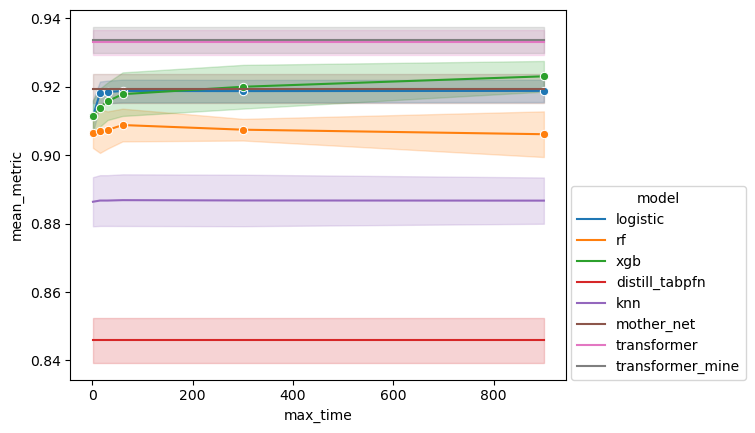

In [74]:
compare_splits = results_combined.groupby(["model", "split", "max_time"])['mean_metric'].mean().reset_index()

import seaborn as sns
varies_over_time = ['logistic', 'xgb', 'rf']
compare_splits_varies = compare_splits[compare_splits.model.isin(varies_over_time)]
compare_splits_fixed = compare_splits[~compare_splits.model.isin(varies_over_time)]

color_palette = sns.color_palette()
ax = sns.lineplot(compare_splits_varies, x="max_time", y="mean_metric", hue="model", errorbar="sd", marker="o", palette=color_palette[:len(varies_over_time)])

compare_splits_fixed_dummy = compare_splits_fixed.copy()
compare_splits_fixed_dummy['max_time'] = compare_splits_varies.max_time.max()
sns.lineplot(pd.concat([compare_splits_fixed, compare_splits_fixed_dummy]),
             x="max_time", y="mean_metric", hue="model", errorbar="sd", ax=ax, palette=color_palette[len(varies_over_time):compare_splits.model.nunique()])
sns.move_legend(ax, (1.01, 0))
#ax.set_ylim(0.9, 0.95)

In [78]:
average_over_splits = results_combined.groupby(["dataset", "model", "max_time"]).mean_metric.mean().reset_index()

In [83]:
best_over_time = average_over_splits.groupby(["dataset", "model"]).mean_metric.max().reset_index()
best_over_time

,dataset,model,mean_metric
0,analcatdata_authorship,distill_tabpfn,0.999934
1,analcatdata_authorship,knn,0.999763
2,analcatdata_authorship,logistic,0.999965
3,analcatdata_authorship,mother_net,0.999966
4,analcatdata_authorship,rf,0.999710
...,...,...,...
139,wdbc,mother_net,0.995587
140,wdbc,rf,0.992486
141,wdbc,transformer,0.996465
142,wdbc,transformer_mine,0.996354


In [14]:
from tabpfn.scripts.critical_differences import draw_cd_diagram

best_over_time.columns = ['dataset_name', 'classifier_name', 'accuracy']
res = draw_cd_diagram(best_over_time, title="OVO ROC AUC");

NameError: name 'best_over_time' is not defined